In [95]:
import tensorflow as tf

from tensorflow import keras
from keras import datasets, layers, models
from keras.models import Sequential

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import PIL.Image
from pathlib import Path

In [96]:
batch_size = 32
img_height = 180
img_width = 180
processed_datasets_directory = "data"

In [97]:
train_dir = Path("data/train")
validate_dir = Path("data/validate")


def fetch_datasets(folder_name):
  print("\nFetching datasets in:", folder_name)
  datasets = {}
  for source in Path(processed_datasets_directory + "/" + folder_name).glob("*"):
    datasets[source.name] = tf.keras.utils.image_dataset_from_directory(
      source,
      image_size=(img_height, img_width),
      batch_size=batch_size
    )
  return datasets

test_datasets = fetch_datasets("test")
print("Fetching training dataset")
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size
)
print("Fetching validation dataset")
validate_ds = tf.keras.utils.image_dataset_from_directory(
  validate_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size
)


Fetching datasets in: test
Found 400 files belonging to 4 classes.
Found 12 files belonging to 4 classes.
Found 3924 files belonging to 4 classes.


KeyboardInterrupt: 

['0', '180', '270', '90']


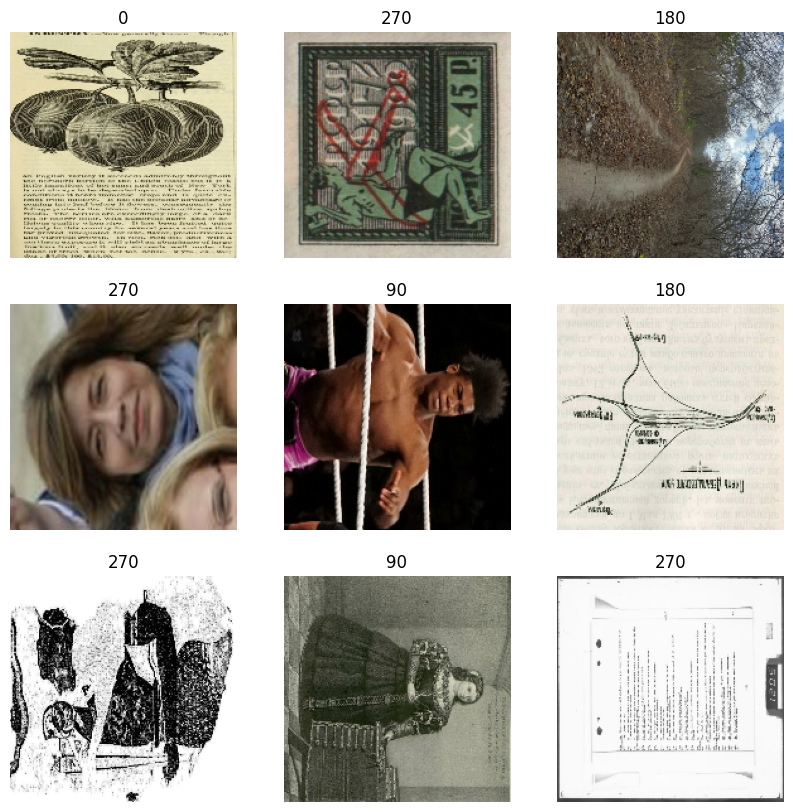

In [ ]:
class_names = train_ds.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

(32, 180, 180, 3)
(32,)
0.00052282 0.98805344


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds_cached = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validate_ds_cached = validate_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Data augmentation

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

## Dropout

In [ ]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_10 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_9 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                

In [99]:
epochs=1
history = model.fit(
  train_ds_cached,
  validation_data=validate_ds_cached,
  epochs=epochs
)

1306/1960 [==================>...........] - ETA: 7:24 - loss: 1.2548 - accuracy: 0.4199

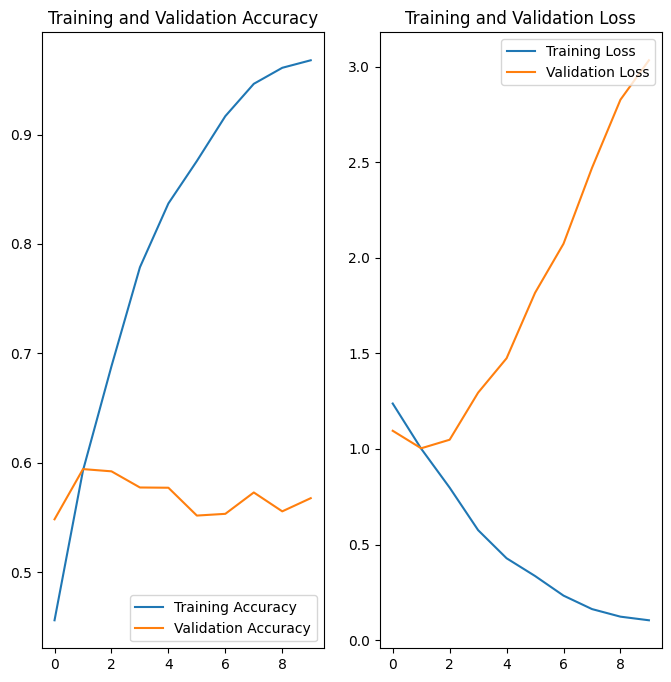

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## References
 - https://www.tensorflow.org/tutorials/load_data/images
 